# The intrinsic sparsity of multiclass-ECE

Here we explore the sparsity of the bins with actual instances in high dimentional spaces, and how this fact makes the multiclass-ECE not suitable for large number of classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

seed = 42

## Uniform samples in a hypercube

We start by showing how the sparsity araises in a uniformly sampled hypercube while increasing the number of dimensions. We first divide each hypercube into 10 bins per dimension ($\#bins = 10^{dimensions}$), and calculate how many samples fall into each bin. Then we show a histogram of how many samples each of the bins has. Given the computational limitations of the function that stores the counts in each bin, we can not show results for more than 8 dimensions.

We can see from the resulting histograms that with 1 dimension, the samples are mostly uniformly distributed accross the bins, resulting in 1 or 2 bins with the similar number of samples. As the number of dimentions increases we can see the majority of the bins having zero samples.

MemoryError with n_features = 9
Unable to allocate 38.4 GiB for an array with shape (5159780352,) and data type int64


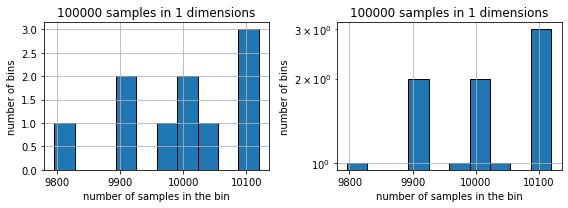

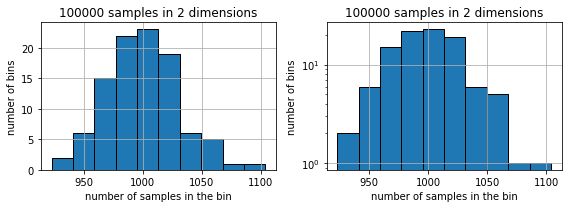

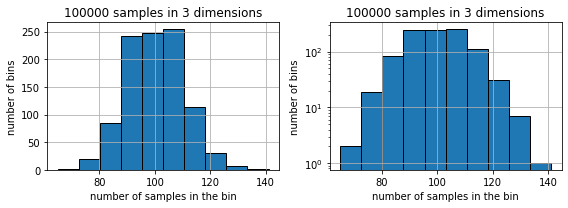

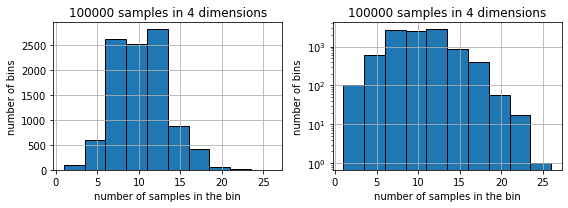

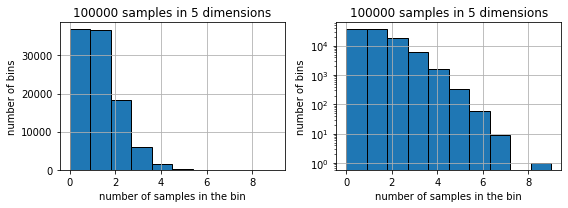

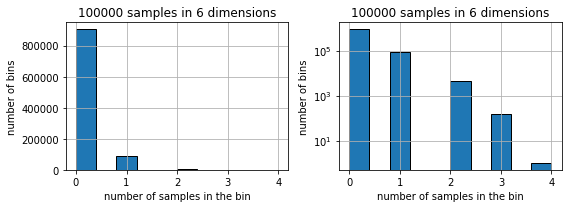

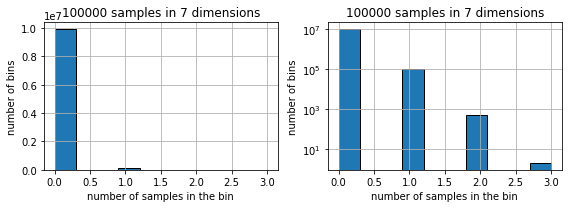

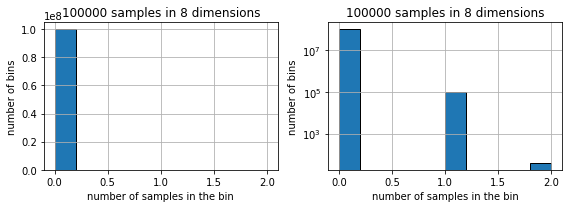

In [2]:
n_samples = 100000
n_feat_list = range(1, 10)
for n_features in n_feat_list:
    X = np.random.uniform(low=0, high=1, size=(n_samples, n_features))
    try:
        H, edges = np.histogramdd(X)
    except MemoryError as e:
        print('MemoryError with n_features = {}'.format(n_features))
        print(e)
        continue
    fig, ax_list = plt.subplots(ncols=2, figsize=(8, 3))
    for i, ax in enumerate(ax_list):
        ax.set_title('{} samples in {} dimensions'.format(n_samples, n_features))
        ax.hist(H.flatten(), edgecolor='black')
        ax.set_ylabel('number of bins')
        ax.set_xlabel('number of samples in the bin')
        ax.grid()
        if i == 1:
            ax.set_yscale('log')
    fig.tight_layout()

## Probabilistic scores of a classifier

The same phenomena shown previously for a uniform hypercube happens with probability scores output by a multiclasss classifier. As the number of classes increases, the number of samples in each bin decreases quickly to zero, with most of the bins having zero or 1 sample.

In [3]:
from sklearn.datasets import make_blobs, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



def generate_blobs(n_samples, n_features, n_classes, random_state):
    centers = n_classes**3
    x, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      random_state=random_state)
    y %= n_classes
    return x, y

def generate_classification(n_samples, n_features, n_classes, random_state):
    n_clusters_per_class = n_classes*3
    n_informative = int(np.sqrt(n_classes * n_clusters_per_class) + 1)
    n_redundant = max(0, n_features - n_informative)
    #print('n_classes', n_classes)
    #print('n_clusters_per_class', n_clusters_per_class)
    #print('n_features', n_features)
    #print('n_informative', n_informative)
    #print('n_redundant', n_redundant)
    x, y = make_classification(n_samples=n_samples, n_classes=n_classes,
                               n_features=n_features, 
                               n_informative=n_informative,
                               n_redundant=n_redundant,
                               n_clusters_per_class=n_clusters_per_class,
                               random_state=random_state)
    return x, y

In [4]:
n_samples = 10000
CLF = RandomForestClassifier
data_generator = generate_classification

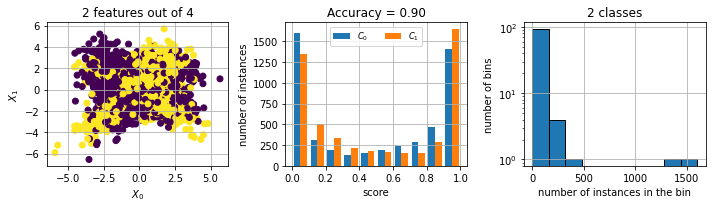

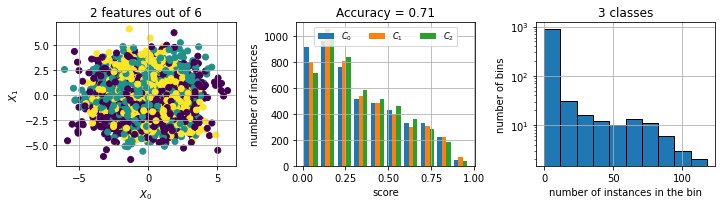

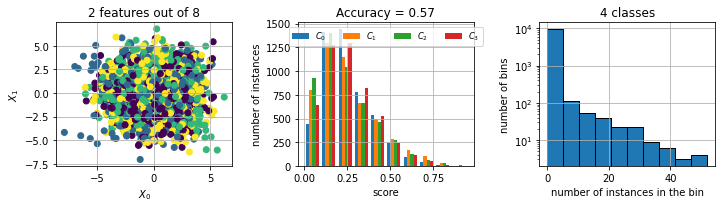

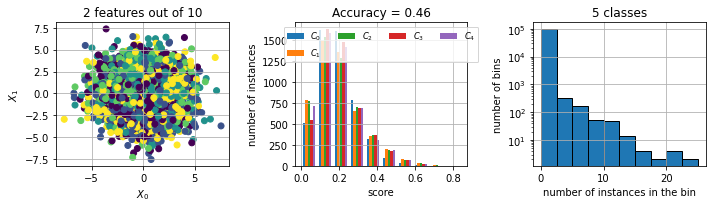

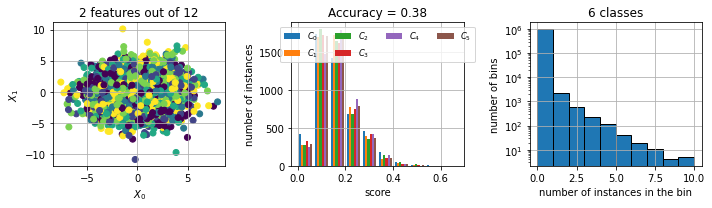

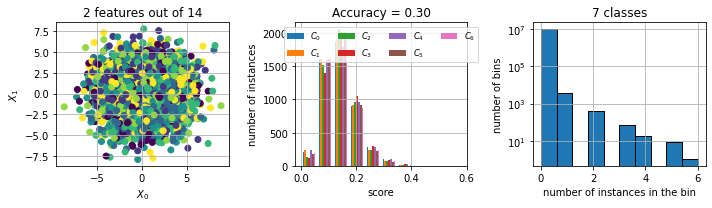

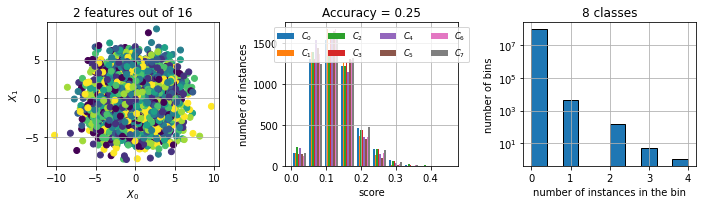

In [5]:
for n_classes in range(2, 9):
    n_features = n_classes*2
    x, y = data_generator(n_samples, n_features, n_classes, random_state=seed)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5)

    clf = CLF()
    clf.fit(x_train, y_train)

    q_test = clf.predict_proba(x_test)
    y_pred = np.argmax(q_test, axis=1)

    fig, ax_list = plt.subplots(ncols=3, figsize=(10, 3))
    ax_list[0].scatter(x_train[:,0], x_train[:,1], c=y_train)
    ax_list[0].set_title('2 features out of {}'.format(n_features))
    ax_list[0].set_xlabel('$X_0$')
    ax_list[0].set_ylabel('$X_1$')
    ax_list[0].grid()
    
    ax_list[1].hist(q_test, label=["$C_{}$".format(i) for i in range(n_classes)])
    ax_list[1].set_title('Accuracy = {:0.2f}'.format(accuracy_score(y_test, y_pred)))
    ax_list[1].set_xlabel('score')
    ax_list[1].set_ylabel('number of instances')
    ax_list[1].grid()
    ax_list[1].legend(fontsize='small', loc='upper center', ncol=4)

    try:
        H, edges = np.histogramdd(q_test)
        ax_list[2].hist(H.flatten(), edgecolor='black')
    except MemoryError as e:
        print(e)
        pass
    ax_list[2].set_title('{} classes'.format(n_classes))
    ax_list[2].set_ylabel('number of bins')
    ax_list[2].set_xlabel('number of instances in the bin')
    ax_list[2].set_yscale('log')
    ax_list[2].grid()
    fig.tight_layout()